虽然我们前面一直在讲图像分类的问题，但是实际上，cv任务在真实工业界中更多是物体检测的问题

在物体检测领域，有一个很重要的概念是边缘框，其实也就是用一个矩形框来把物体给框住，当然后面也可以做更为精细的那种边框
* 边框通常会由四个数字来定义，(左上坐标，右下坐标)或者是（左上坐标，宽和高）
* 对于目标检测数据集来说，我们也需要和图片分类数据集不一样的样本表示方式
    * 如果用文本文件来存，最简单方法是每一行是一个物体，然后这一行有文件名字信息（也就是一张图），物体所属的类别，边缘框的坐标
    * 一个常见数据集叫COCO

接下来我们来实际看看边缘框是怎么实现的

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

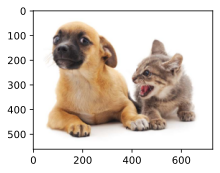

In [2]:
d2l.set_figsize()
img = d2l.plt.imread('../d2l-zh-git-repo/img/catdog.jpg')
d2l.plt.imshow(img);

In [3]:
# 下面定义的这两个函数就是两种边缘框的表示方法的实现
# 不过这个中间高宽的表示方法貌似是第三种，不过无所谓啦，都是一个物体对应一个框，然后有4个feature，这4个feature就能表示这个框

#@save
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [4]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

# 简单测试一下
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

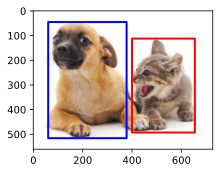

In [5]:
# 这里是个辅助函数，不过matplotlib用的不是很熟悉，不太清楚具体咋作用的
#@save
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)


fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

object detection有一个很奇怪的问题，就是他不存在很小的数据集，所以李沐老师写书的时候收集并且标注了一个小的数据集

In [6]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [7]:
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    # csv_data.iterrows()是构造了一个迭代器，将DataFrame迭代为(insex, Series)对
    # 然后能通过列名访问
    for img_name, target in csv_data.iterrows():
        # 然后我们用io接口，通过名字把image读取了
        # 这里的img_name是index，target是对应行的元素
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    # 这里unsqueeze函数是在维度1上面新增加的了一个维度，原来就是一个长度5的向量，现在是大小为51的矩阵
    # 后面除256是因为，为了把位置信息转化成01之间，因为好像每张图都是256大小的......
    # 而且类别全部写的都是0，无所谓
    # 但是这里我们要注意一点，也就是我们上面通过一个for loop，其实把数据集里面的所有样本读进来了
    # 所以这里大小是n5的一个矩阵，n是样本数
    # 后面就是n15的矩阵，这其实就和torch里面的规定对应上了，第一维是批量大小，第二维是通道数量（这里是1，因为我们要识别的只有1个类别，如果多个类别，这里会是别的），第三位与后面的才是feature
    # 所以我们这里才要手动添加一个维度上去，因为维度大小为1会被自动忽略
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [8]:
# 这种定义数据集的方法很有意思啊，感觉可以注意一下
# 难道是torch需要这样定义？
# 哦是的，继承了torch.utils.data.Dataset
#@save
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    # 这里两个函数都是torch的Dataset所需要的
    def __getitem__(self, idx):
        # 读取特定的样本，这个估计是调数据的时候需要的实现，比如你想要看第几个数据之类的
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        # 这个就是知道数据的长度，算一下一个data epoch要多少个batch之类的
        return len(self.features)

In [9]:
#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

# 结合上面的我们会发现，train_iter[0]这里大小是[32, 3, 256, 256]，train_iter[1]这里大小是[32, 1, 5]
# 上面这个1就表示，我们一张图片只会有一个类别的物体要识别（因为一张图片就是一个样本嘛）
# 这其实也就是feature和label，我们的输入和输出，X和y

In [10]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

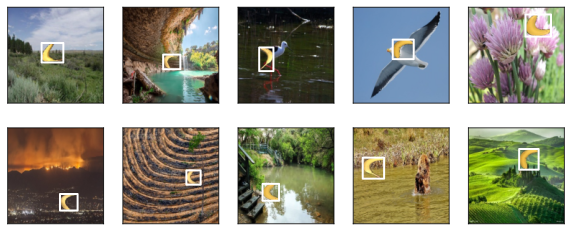

In [12]:
# 这里用了个permute函数，就是把0123这几个维度重新排序，符合matplotlib的要求
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

这节课主要是讲了，如何从原始样本处理一个物体识别的数据集，让它能够扔进我们的框架里面去训练
* 感觉这种数据处理的方式非常优雅，需要注意，比如到时候写在utils module里面